# Tarea 1 INF 395

Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

In [339]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
!pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

!pip install sklearn

## Integrantes:

* Nombre: Felipe Guzmán
* Nombre: Simón Appel

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


## Helper Functions

In [3]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [4]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [5]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [6]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### Exploración de los Datos

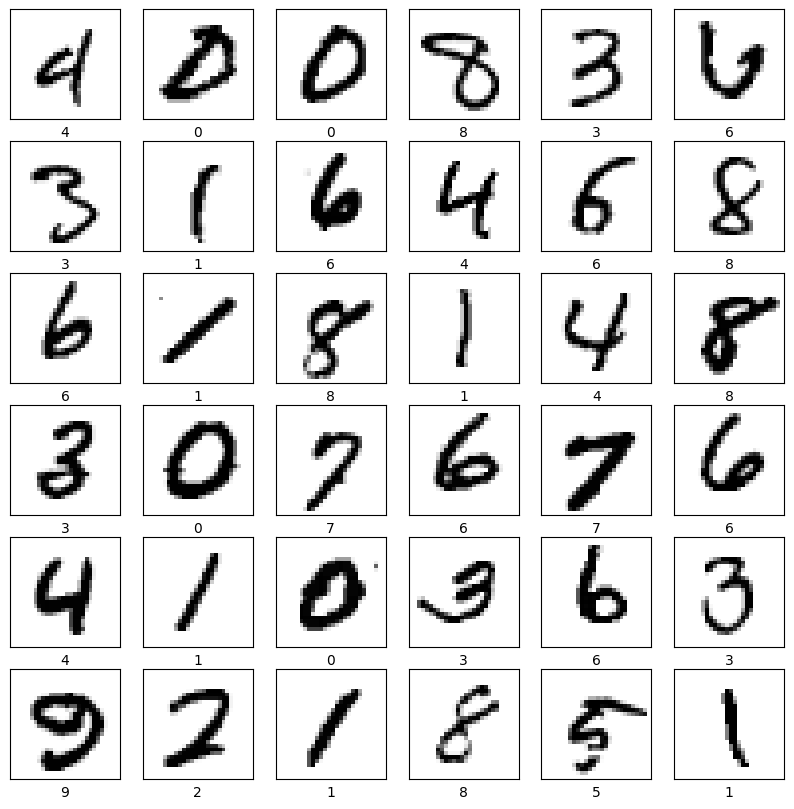

In [7]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [8]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [9]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [5 0 4 ... 5 6 8]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [10]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

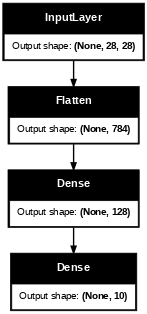

In [11]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

#### Definición de hiperparámetros

In [12]:
# definimos algunos hiperparámetros
batch_size = 128        #cantidad de imágenes por batch
epochs = 20             #cantidad de epochs
validation_split = 0.2  #Porcentaje de data destinada a validación

In [13]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [14]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6077 - loss: 17.2967 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7962 - loss: 0.9616 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8409 - loss: 0.6901 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8647 - loss: 0.5500 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8799 - loss: 0.4683 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8914 - loss: 0.4117 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9014 - loss: 0.3691 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9085 - loss: 0.3359 - val_accuracy:

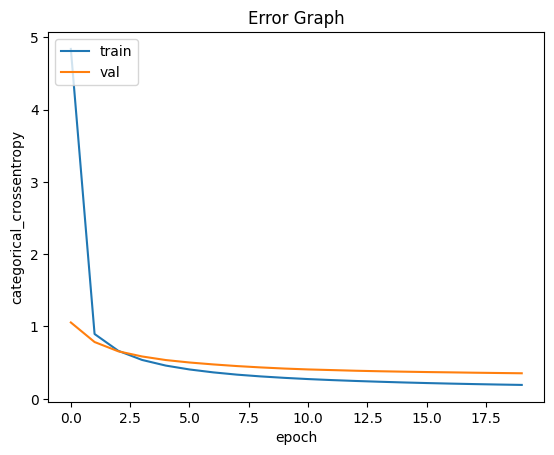

In [15]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36804893612861633
Test accuracy: 0.9214000105857849


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


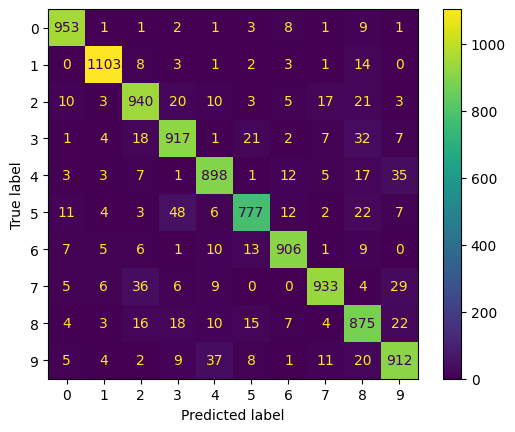

In [17]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: 'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.

In [18]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [19]:
#Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


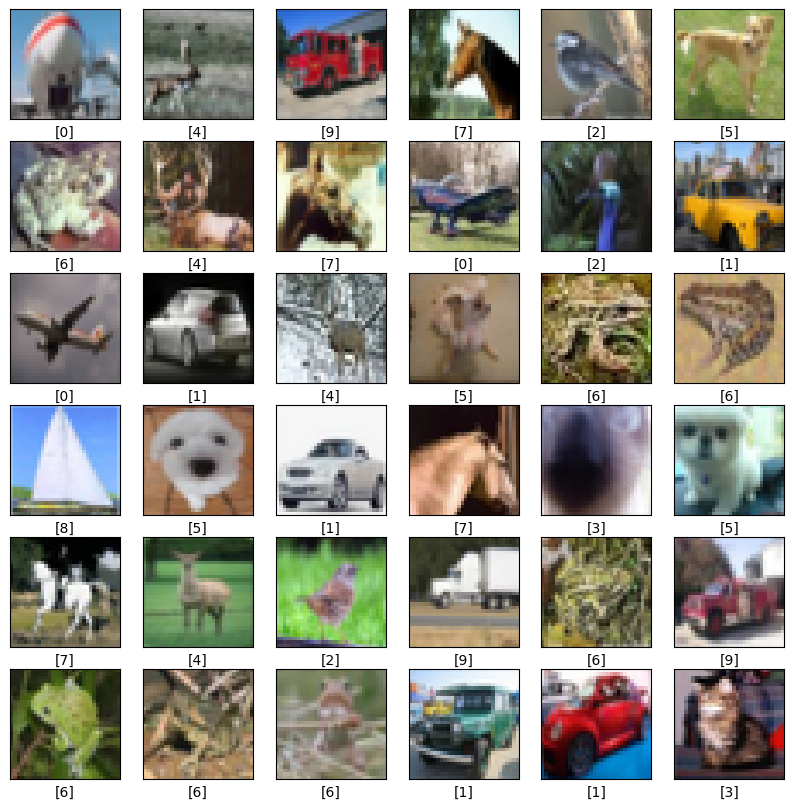

In [20]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [21]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


In [22]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [23]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

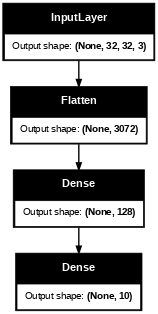

In [24]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [25]:
# definimos algunos hiperparámetros
batch_size = 128
epochs = 20
validation_split = 0.2

In [26]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [27]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1021 - loss: 582.5865 - val_accuracy: 0.0953 - val_loss: 2.3144
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1018 - loss: 2.3032 - val_accuracy: 0.0953 - val_loss: 2.3126
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1017 - loss: 2.3021 - val_accuracy: 0.0954 - val_loss: 2.3128
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1019 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3130
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3125
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy:

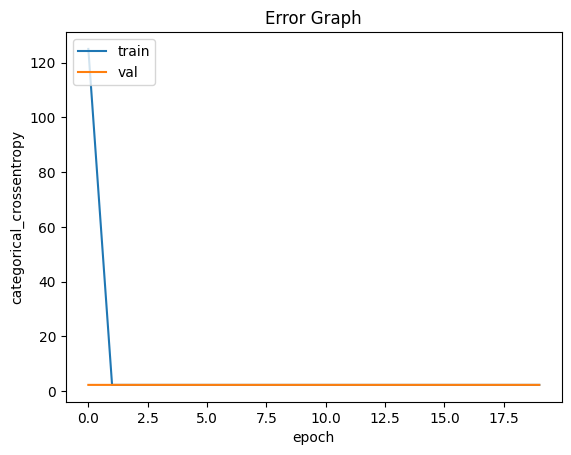

In [28]:
plot_losses(history, loss)

In [29]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


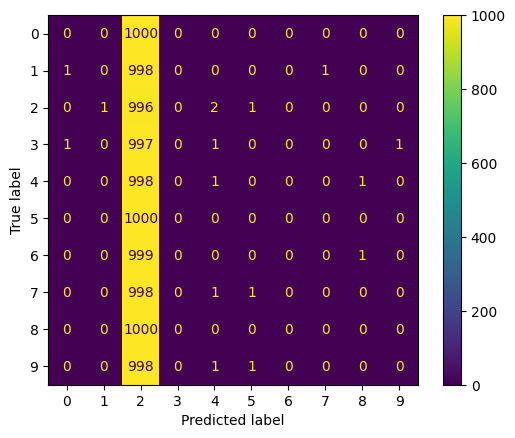

In [30]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [31]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1000
     class 1       0.00      0.00      0.00      1000
     class 2       0.10      1.00      0.18      1000
     class 3       0.00      0.00      0.00      1000
     class 4       0.17      0.00      0.00      1000
     class 5       0.00      0.00      0.00      1000
     class 6       0.00      0.00      0.00      1000
     class 7       0.00      0.00      0.00      1000
     class 8       0.00      0.00      0.00      1000
     class 9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos observar como este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [32]:
#Es una práctica común en modelos de machine learning escalar nuestros datos, asi nos aseguramos de que todos tengan el mismo rango, con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.

#Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [33]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (6.67 MB)

 Trainable params: 1,748,266 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]**

`Respuesta:` Las capas de Droput permite robustecer el modelo mediante la independizacion de cada neurona y no depender de la cadena de información para dar cierto valor. Digase, permite entrenar la neurona per-se y permite mayor precision por parte de la capa/neurona ante la data.

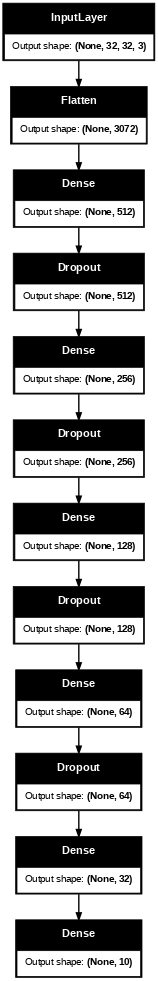

In [34]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [35]:
#Agregamos Callbacks
#Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado, lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [36]:
#Cambiamos el Optimizador a Adam
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.Adam(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [37]:
# agregamos más epoochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [38]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.1595 - loss: 2.2495 - val_accuracy: 0.2884 - val_loss: 1.9552
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2917 - loss: 1.9233 - val_accuracy: 0.3400 - val_loss: 1.8372
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3250 - loss: 1.8413 - val_accuracy: 0.3614 - val_loss: 1.7739
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3450 - loss: 1.8014 - val_accuracy: 0.3687 - val_loss: 1.7544
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3615 - loss: 1.7560 - val_accuracy: 0.3664 - val_loss: 1.7608
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3803 - loss: 1.7257 - val_accuracy: 0.4079 - val_loss: 1.6685
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3847 - loss: 1.7005 - val_accuracy: 0.4059 - val_loss: 1.6560
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3939 - loss: 1.6710 - val_ac

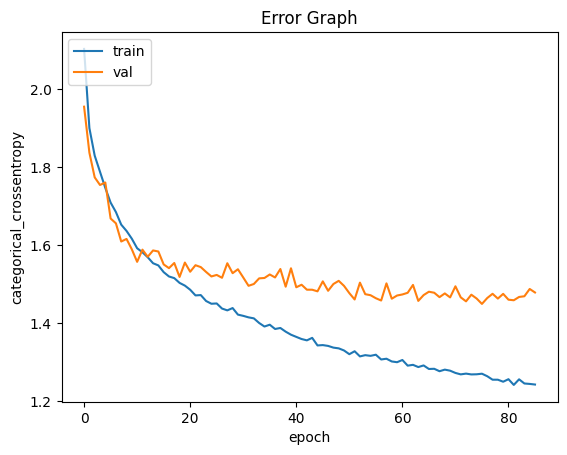

In [39]:
plot_losses(history, loss)

In [40]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4232674837112427
Test accuracy: 0.49399998784065247


Aún estamos con un accuracy del 0.5, eso seria equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


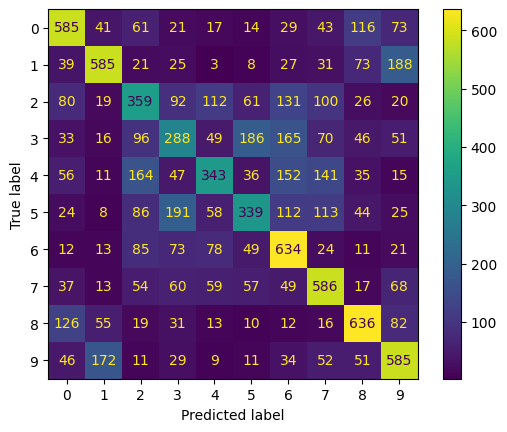

In [41]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [42]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.58      0.57      1000
     class 1       0.63      0.58      0.61      1000
     class 2       0.38      0.36      0.37      1000
     class 3       0.34      0.29      0.31      1000
     class 4       0.46      0.34      0.39      1000
     class 5       0.44      0.34      0.38      1000
     class 6       0.47      0.63      0.54      1000
     class 7       0.50      0.59      0.54      1000
     class 8       0.60      0.64      0.62      1000
     class 9       0.52      0.58      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



### 1.2.3 Último Modelo ahora Con Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y como lo hacen? [3pts]**

`Respuesta:` El 'Skip Connection' permite eliminar dependencias entre capas ocultas adyacentes mediante 'saltos' de capas vecinas y conectarlas con layers mas lejanas. Esto, digase, permite eliminar el efecto de una capa a otra con respecto a desvanecer/modificar valores, permitiendo que mas capas tengan esa información para procesar.

In [43]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (29.77 MB)

 Trainable params: 7,803,338 (29.77 MB)

 Non-trainable params: 896 (3.50 KB)

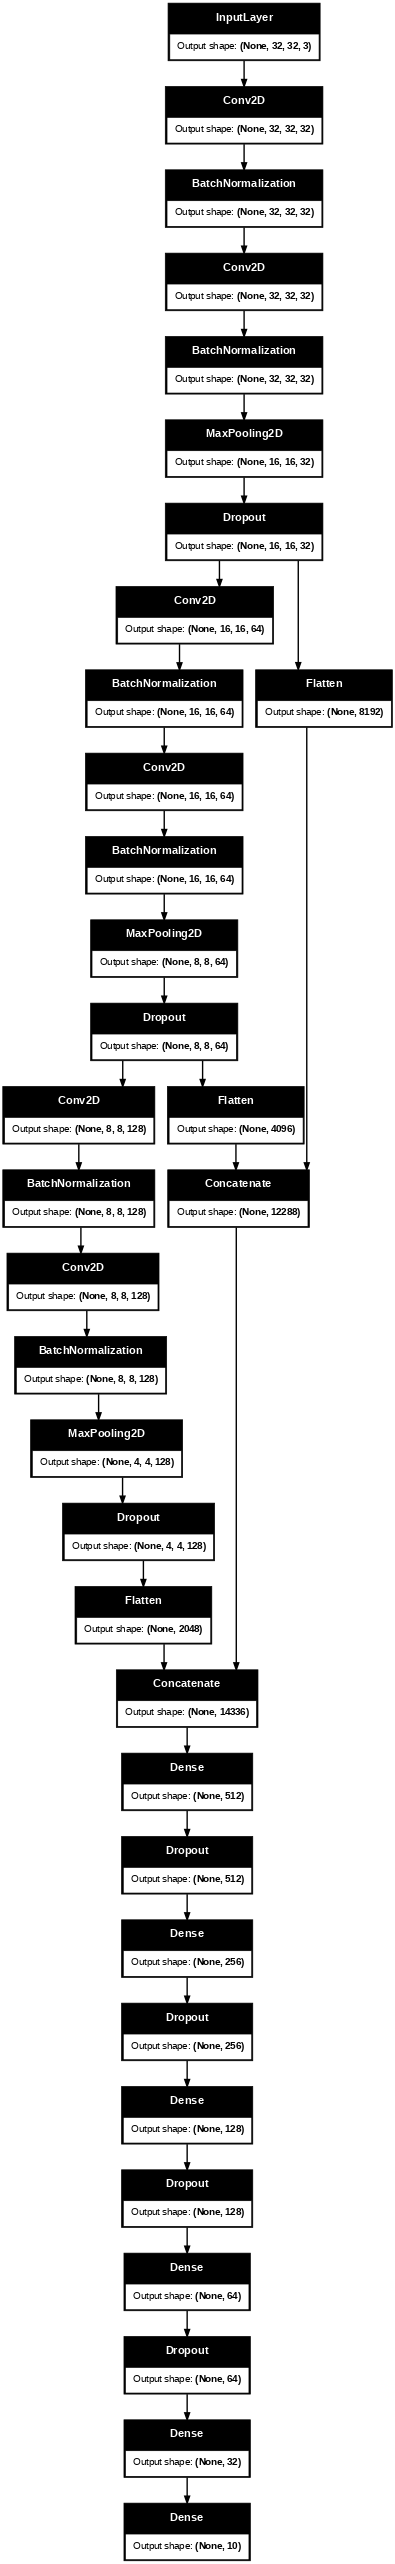

In [44]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [45]:
#Cambiamos el Optimizador a AdamW
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [46]:
#Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [47]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [48]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.2268 - loss: 2.6843 - val_accuracy: 0.3167 - val_loss: 1.8637
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4721 - loss: 1.4688 - val_accuracy: 0.5557 - val_loss: 1.2546
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5837 - loss: 1.1851 - val_accuracy: 0.6442 - val_loss: 1.0198
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6628 - loss: 0.9763 - val_accuracy: 0.7032 - val_loss: 0.9021
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7233 - loss: 0.8083 - val_accuracy: 0.7364 - val_loss: 0.8009
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7701 - loss: 0.6829 - val_accuracy: 0.7356 - val_loss: 0.8483
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8040 - loss: 0.5789 - val_accuracy: 0.7587 - val_loss: 0.7840
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8415 - loss: 0.4789 

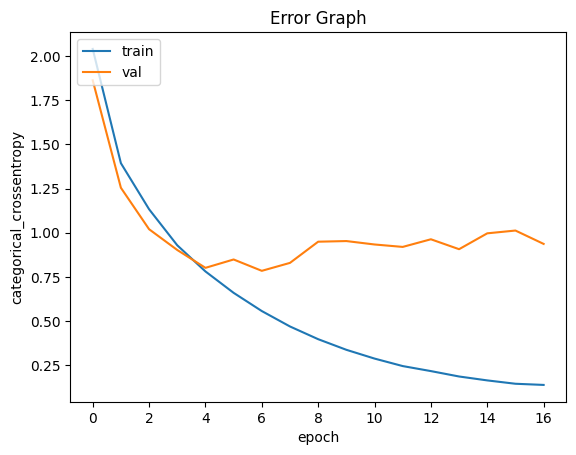

In [49]:
plot_losses(history, loss)

In [50]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8184977173805237
Test accuracy: 0.7487999796867371


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


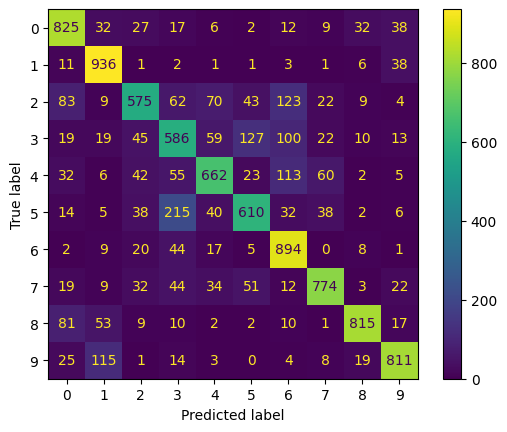

In [51]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [52]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.74      0.82      0.78      1000
     class 1       0.78      0.94      0.85      1000
     class 2       0.73      0.57      0.64      1000
     class 3       0.56      0.59      0.57      1000
     class 4       0.74      0.66      0.70      1000
     class 5       0.71      0.61      0.65      1000
     class 6       0.69      0.89      0.78      1000
     class 7       0.83      0.77      0.80      1000
     class 8       0.90      0.81      0.86      1000
     class 9       0.85      0.81      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [53]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) #Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

#Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

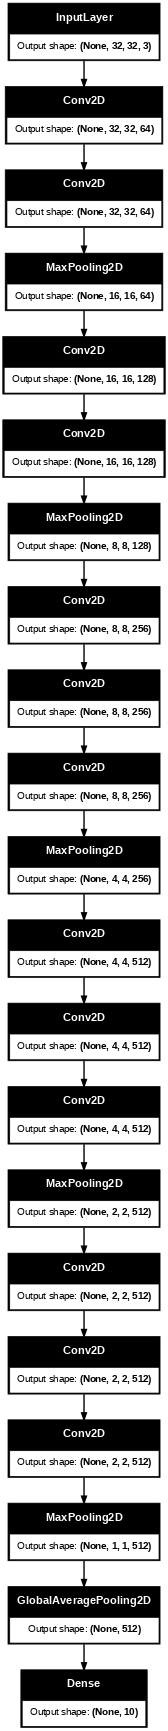

In [54]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [55]:
#Cambiamos el Optimizador
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [56]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.2907 - loss: 2.0249 - val_accuracy: 0.4853 - val_loss: 1.5376
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5002 - loss: 1.4875 - val_accuracy: 0.5189 - val_loss: 1.4136
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5312 - loss: 1.3800 - val_accuracy: 0.5375 - val_loss: 1.3556
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5509 - loss: 1.3241 - val_accuracy: 0.5481 - val_loss: 1.3198
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5632 - loss: 1.2874 - val_accuracy: 0.5561 - val_loss: 1.2950
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5717 - loss: 1.2607 - val_accuracy: 0.5617 - val_loss: 1.2768
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5779 - loss: 1.2400 - val_accuracy: 0.5663 - val_loss: 1.2627
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5832 - loss: 1.22

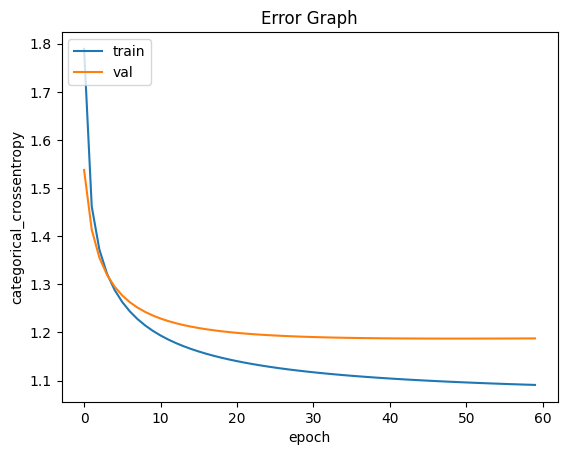

In [57]:
plot_losses(history, loss)

In [58]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1918489933013916
Test accuracy: 0.5856999754905701


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


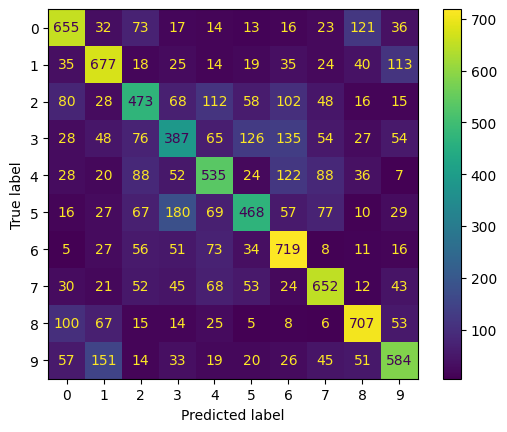

In [59]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [60]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.63      0.66      0.64      1000
     class 1       0.62      0.68      0.65      1000
     class 2       0.51      0.47      0.49      1000
     class 3       0.44      0.39      0.41      1000
     class 4       0.54      0.54      0.54      1000
     class 5       0.57      0.47      0.51      1000
     class 6       0.58      0.72      0.64      1000
     class 7       0.64      0.65      0.64      1000
     class 8       0.69      0.71      0.70      1000
     class 9       0.61      0.58      0.60      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000



Podemos observar cómo no obtenemos resultados tan buenos como la red anterior pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Datset Guiado

### 2.1 Exploracion de la Data

In [348]:
df = pd.read_csv('Steel_industry_data.csv')

In [322]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [ ]:
df.info()

**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

In [ ]:
sns.pairplot(df, hue='Load_Type')

In [ ]:
# Gráficos del EDA - Boxplots
mask = df['Load_Type'] == 'Light_Load'
kde_df = pd.DataFrame(df[mask]["Usage_kWh"])

f, ax = plt.subplots(2, 1,figsize=(5,7))
ax[0].set_xscale("log")
sns.boxplot(ax=ax[0],x=df["Usage_kWh"], y=df["Load_Type"])
sns.kdeplot(ax=ax[1],data=np.log1p(kde_df))

In [232]:
vis_df = df.copy()

daySelector = lambda x: np.sum(vis_df.groupby(["Day_of_week"]).get_group(x)[["Usage_kWh"]])
consumption_df = pd.DataFrame()

for x in vis_df["Day_of_week"].unique():
  consumption_df[x] = daySelector(x)

consumption_df = consumption_df

In [ ]:
sns.barplot(consumption_df)

### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [351]:
# Dividir la data considerando el split indicado anteriormente (se recomienda separar en train y test en esta sección, y separar en validación en la sección de entrenamiento)
### START CODE HERE ###
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)



*   `Training`: Es el conjunto conocido para entrenar el modelo. Es el que contiene la mayor parte de la data, ya que necesita de bastante informacion para poder balancear los pesos.
*   `Validation`: Es un sub-set del conjunto de `Testing`, pero no para testearlo derechamente, si no que permite una evaluacion previa y "Validar" el modelo, ya que se enfrentaria a data nueva, dando información sin bias alguno.
*   `Testing`: Es el conjunto que finalmente pone a prueba el modelo y el cual dictamina la eficacia del modelo.



### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas
2.   Variables categóricas

#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

In [226]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [227]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

,sin_day,cos_day
0,0.017213,0.999852
1,0.034422,0.999407
2,0.051620,0.998667
3,0.068802,0.997630
4,0.085965,0.996298


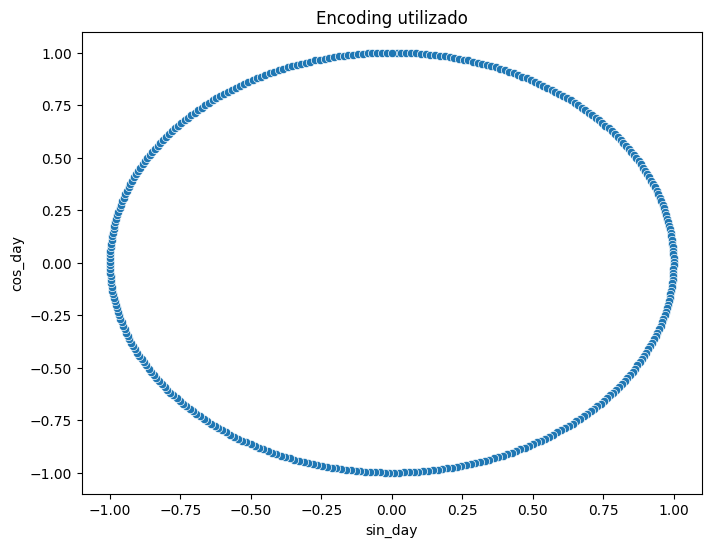

In [228]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

`Respuesta`: La data de tipo `Fecha` al ser un tipo de dato distinto, secuencial y dificil de tratar ante la maquina y su computación, ya que no siempre se quiere interpretar como ordinal. Se utiliza la aproximación periodica mediante un acercamiento mas "matematico" de funciones que, asi lo son como las trigonometricas, permiten representar la fecha mediante su computo.

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]




*   `One-Hot Encoding`: El One-Hot o Dummy, como el nombre dice, es "Uno Encendido". Es una transformacion que permite una feature categorica, llevarla a varias columnas las cuales indicarán "1" a los experimentos que los contenga, de otro modo tendran un "0". Es decir, crea N columnas por N cantidad de categorias en la caracteristica y "mappea" cuales puntos son de esa categoria y les asigna un "1".
*   `Ordinal Encoding`: Es una trasformacion que permite generar una numerizacion de una caracteristica ordinal. Se entiende por ordinal, un tipo de variable categorica por peldaños, las cuales ambos extremos simbolizan algo opuesto. I.e. "$x \in \{1,2,3,4,5\}$ estrellas de un hotel". Por ende, permite "mappear" la representacion no numerica a un numero, como lo que es un ENUM en C.
*   `Label Encoding`: Hace basicamente lo mismo que el OrdinalEnconding. La difierencia es donde se aplica. Generalmente se utiliza en las variables a predecir, para transoformar los strings objetivos a numeros, lo cual a la maquina le "hace mas sentido". De ahí el nombre del encoding, _Label_, se refiere al target a predecir.

**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [349]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
# preprocesamiendo indicado

## SCALER - MINMAX
minmax = MinMaxScaler()
new_CO2 = minmax.fit_transform(df[["CO2(tCO2)"]])
new_NSM = minmax.fit_transform(df[["NSM"]])

## SCALER - STANDARD
scaler = StandardScaler()

new_LagCurrentReactivePower = scaler.fit_transform(df[["Lagging_Current_Reactive.Power_kVarh"]])
new_LeadCurrentReactivePower = scaler.fit_transform(df[["Leading_Current_Reactive_Power_kVarh"]])

new_LagCurrentReactivePowerFactor = scaler.fit_transform(df[["Lagging_Current_Power_Factor"]])
new_LeadCurrentReactivePowerFactor = scaler.fit_transform(df[["Leading_Current_Power_Factor"]])

## ENCODER - ORDINAL
ordEnc = OrdinalEncoder()
new_LoadType = ordEnc.fit_transform(df[["Load_Type"]])

## ENCODER - ONE-HOT
oneEnc = OneHotEncoder()
new_WeekStatus = oneEnc.fit_transform(df[["WeekStatus"]])

## ENCODER - LABEL
lblEnc = LabelEncoder()
new_Day_of_Week = lblEnc.fit_transform(df[["Day_of_week"]])

## ENCODER - SINUSOIDAL

dates = pd.to_datetime(df["date"],format='%d/%m/%Y %H:%M')

df["new_date_day"] = dates.dt.day
df["new_date_month"] = dates.dt.month
df["new_date_hour"] = dates.dt.hour


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [350]:
# Asignando Nuevos atributos

## SCALER - MINMAX
df["CO2(tCO2)"] = new_CO2
df["NSM"] = new_NSM

## SCALER - STANDARD
df["Lagging_Current_Reactive.Power_kVarh"] = new_LagCurrentReactivePower
df["Leading_Current_Reactive_Power_kVarh"] = new_LeadCurrentReactivePower
df["Lagging_Current_Power_Factor"] = new_LagCurrentReactivePowerFactor
df["Leading_Current_Power_Factor"] = new_LeadCurrentReactivePowerFactor

## ENCODER - ORDINAL
df["Load_Type"] = new_LoadType

## ENCODER - ONE-HOT
df = pd.get_dummies(df, columns=["WeekStatus"], drop_first=True)

## ENCODER - LABEL
df["Day_of_week"] = new_Day_of_Week

## ENCODER - SINUSOIDAL
df.drop(["date"],axis=1,inplace=True)
df.append(preprocess_time(df, "new_date_day", 31))
df.append(preprocess_time(df, "new_date_month", 12))
df.append(preprocess_time(df, "new_date_hour", 24))

<ipython-input-350-31ad5ffd25dc>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(preprocess_time(df, "new_date_day", 31))
<ipython-input-350-31ad5ffd25dc>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(preprocess_time(df, "new_date_month", 12))
<ipython-input-350-31ad5ffd25dc>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(preprocess_time(df, "new_date_hour", 24))


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekend,sin_new_date_day,cos_new_date_day,sin_new_date_month,cos_new_date_month,sin_new_date_hour,cos_new_date_hour
0,3.17,-0.618516,-0.521385,0.0,-0.389410,0.513268,0.010526,1,0.0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.000000,1.000000
1,4.00,-0.525911,-0.521385,0.0,-0.729772,0.513268,0.021053,1,0.0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.000000,1.000000
2,3.24,-0.598278,-0.521385,0.0,-0.544264,0.513268,0.031579,1,0.0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.000000,1.000000
3,3.31,-0.581106,-0.521385,0.0,-0.660009,0.513268,0.042105,1,0.0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.258819,0.965926
4,3.82,-0.523458,-0.521385,0.0,-0.838117,0.513268,0.052632,1,0.0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.258819,0.965926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,3.85,-0.501380,-0.521385,0.0,-0.976587,0.513268,0.968421,1,0.0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.258819,0.965926
35036,3.74,-0.570067,-0.521385,0.0,-0.521538,0.513268,0.978947,1,0.0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.258819,0.965926
35037,3.78,-0.605024,-0.511957,0.0,-0.209188,0.512611,0.989474,1,0.0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.258819,0.965926
35038,3.78,-0.611770,-0.506569,0.0,-0.151052,0.511954,1.000000,1,0.0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.258819,0.965926


### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir

In [352]:
# Separar la columna a predecir "Usage_kWh" y los datos para entrenar
### START CODE HERE ###

mask = df.columns != 'Usage_kWh'

y_train = df_train["Usage_kWh"]
X_train = df_train.drop("Usage_kWh",inplace=False,axis=1)

y_test = df_test["Usage_kWh"]
X_test = df_test.drop("Usage_kWh",inplace=False,axis=1)

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, aca queda a libre elección si quieren utilizar la API secuencial o funcional, y tambien queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [353]:
#Crear un modelo de Keras a libre elección
### START CODE HERE ###
inputs = keras.layers.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(6, activation='tanh')(inputs)

output = keras.layers.Dense(1,activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 15)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_24 (Dense)                │ (None, 6)                 │         96 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_25 (Dense)                │ (None, 1)                 │          7 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 103 (412.00 B)

 Trainable params: 103 (412.00 B)

 Non-trainable params: 0 (0.00 B)

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`: Derechamente, a lo mas una sola hidden y estimaría casi que una neurona. Ya que es una combinacion lineal de los elementos por lo que, al ser una recta, se facilita el proces de construccin de la red.

Y la de activación, personlamente abogo por la `linear` para su salida y si hay alguna hidden, una `tanh`. ReLu tiene un "bias" frente a los numeros negativos y sus variantes.

Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [354]:
### START CODE HERE ###
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

In [355]:
### START CODE HERE ###
val_split = 0.2
batch_size = 128
epochs = 200

my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

### 2.6 Entrenando el Modelo

In [356]:
### START CODE HERE ###
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1813.2743 - mean_absolute_error: 26.4641 - mean_squared_error: 1813.3171 - root_mean_squared_error: 42.5788 - val_loss: 1817.2848 - val_mean_absolute_error: 26.3122 - val_mean_squared_error: 1815.4489 - val_root_mean_squared_error: 42.6081
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1720.7253 - mean_absolute_error: 25.1717 - mean_squared_error: 1720.7665 - root_mean_squared_error: 41.4784 - val_loss: 1739.7948 - val_mean_absolute_error: 25.2724 - val_mean_squared_error: 1737.9768 - val_root_mean_squared_error: 41.6890
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1648.1079 - mean_absolute_error: 24.2621 - mean_squared_error: 1648.1479 - root_mean_squared_error: 40.5937 - val_loss: 1668.3212 - val_mean_absolute_error: 24.6269 - val_mean_squared_error: 1666.5238 - val_root_mean_squared_error: 40.8231
Epoch 4/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1581.2836 - mean_absolute_error: 23

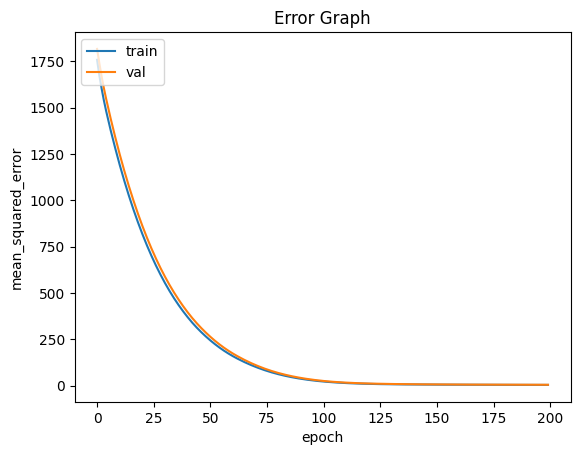

In [357]:
plot_losses(history, loss)

In [370]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 3.5151894092559814
Test accuracy: 0.926977276802063


### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [371]:
model.save('steel_ind_regression.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.